In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from yahoofinancials import YahooFinancials as yfs
from datetime import datetime
import seaborn as sns
import yfinance as yf
%matplotlib widget
sns.set_style("darkgrid")
sns.set(font_scale=1.7)


In [3]:
buy_ticker = "VLY"
sell_ticker = "EVRI"
beta_ticker = yf.Ticker("SPY")

ticker1 = yf.Ticker(buy_ticker)
ticker2 = yf.Ticker(sell_ticker)
dataFrame1 = ticker1.history(
    start='2017-1-1', actions=True, rounding=True)
dataFrame2 = ticker2.history(
    start='2017-1-1', actions=True, rounding=True)
spy = beta_ticker.history(
    start='2020-1-1', actions=True, rounding=True)

ratio = dataFrame1.Close / dataFrame2.Close
spread = dataFrame1.Close - dataFrame2.Close


In [4]:
# Position financials and dividends:

# Long ticker:
long_p_e = yfs(buy_ticker).get_pe_ratio()
long_div = yfs(buy_ticker).get_dividend_yield()
long_exdiv_date = yfs(buy_ticker).get_exdividend_date()
# Short ticker:
short_p_e = yfs(sell_ticker).get_pe_ratio()
short_div = yfs(sell_ticker).get_dividend_yield()
short_exdiv_date = yfs(sell_ticker).get_exdividend_date()

print(
    f"Long position {buy_ticker} P/E ratio ={long_p_e} and dividend yield is {long_div}. Ex div date {long_exdiv_date}")
print(
    f"short position {sell_ticker} P/E ratio ={short_p_e} and dividend yield is {short_div}. Ex div date {short_exdiv_date}")


Long position VLY P/E ratio =11.742858 and dividend yield is 0.0363. Ex div date 2022-09-14
short position EVRI P/E ratio =10.421212 and dividend yield is None. Ex div date -


In [5]:
##### Position sizing:
# BETA calculation:

spy_ticker1 = pd.concat([spy.Close[-500::], dataFrame1.Close[-500::]], axis=1)
spy_ticker1.columns = ["SPY", buy_ticker]
long_data_pct = np.log(spy_ticker1/spy_ticker1.shift())
ticker1_cov = long_data_pct.cov().iloc[0, 1]
ticker1_var = long_data_pct["SPY"].var()
long_beta = ticker1_cov/ticker1_var

spy_ticker2 = pd.concat(
    [spy.Close[-500::], dataFrame2.Close[-500::]], axis=1)
spy_ticker2.columns = ["SPY", sell_ticker]
short_data_pct = np.log(spy_ticker2/spy_ticker2.shift())
ticker2_cov = short_data_pct.cov().iloc[0, 1]
ticker2_var = short_data_pct["SPY"].var()
short_beta = ticker2_cov/ticker2_var


In [6]:
risk1 = ticker1.history(period="ytd", interval="1mo", actions=False, rounding=True)
risk2 = ticker2.history(period="ytd", interval="1mo", actions=False, rounding=True)

risk1.dropna(axis=0, inplace=True)
risk1["ATR"]=risk1.High-risk1.Low
risk1["ATR %"]=((risk1["ATR"]+risk1["ATR"].shift())/2)/risk1.High

risk2.dropna(axis=0, inplace=True)
risk2["ATR"]=risk2.High-risk2.Low
risk2["ATR %"]=((risk2["ATR"]+risk2["ATR"].shift())/2)/risk2.High

In [11]:
position_size = 2900

#beta ratio:
long_beta_ratio = long_beta/(long_beta+short_beta)
short_beta_ratio = short_beta/(long_beta+short_beta)

# ATR ratio:
long_atr_weigth = risk1["ATR %"].mean(
) / (risk1["ATR %"].mean() + risk2["ATR %"].mean())
short_atr_weigth = risk2["ATR %"].mean(
) / (risk1["ATR %"].mean() + risk2["ATR %"].mean())

print(f"{buy_ticker} beta: ", np.round(long_beta, 2),
      f" and ATR in %: ", np.round(risk1["ATR %"][-2], 2))
print(f"{sell_ticker} beta: ", np.round(short_beta, 2),
      f"and ATR in %: ", np.round(risk2["ATR %"][-2], 2))
print("============================")

# Position size
long_pos_size = position_size * ((short_beta_ratio + short_atr_weigth)/2)
short_pos_size = position_size * ((long_beta_ratio + long_atr_weigth)/2)

print(f"{buy_ticker} long position in $: ", np.round(long_pos_size, 0))
print(f"{sell_ticker} short position in $: ", np.round(short_pos_size, 0))
print("============================")

long_entry = 12.32
short_entry = 17.18

long_shrs = long_pos_size/long_entry
short_shrs = short_pos_size/short_entry

print(f"{buy_ticker} number of shares:", np.round(long_shrs, 0))
print(f"{sell_ticker} number of shares:", np.round(short_shrs, 0))


VLY beta:  1.01  and ATR in %:  0.08
EVRI beta:  1.49 and ATR in %:  0.13
VLY long position in $:  1741.0
EVRI short position in $:  1159.0
VLY number of shares: 141.0
EVRI number of shares: 67.0


Entry: 0.72 Ratio: 0.72 Exit point: 0.62 Target: 1.09


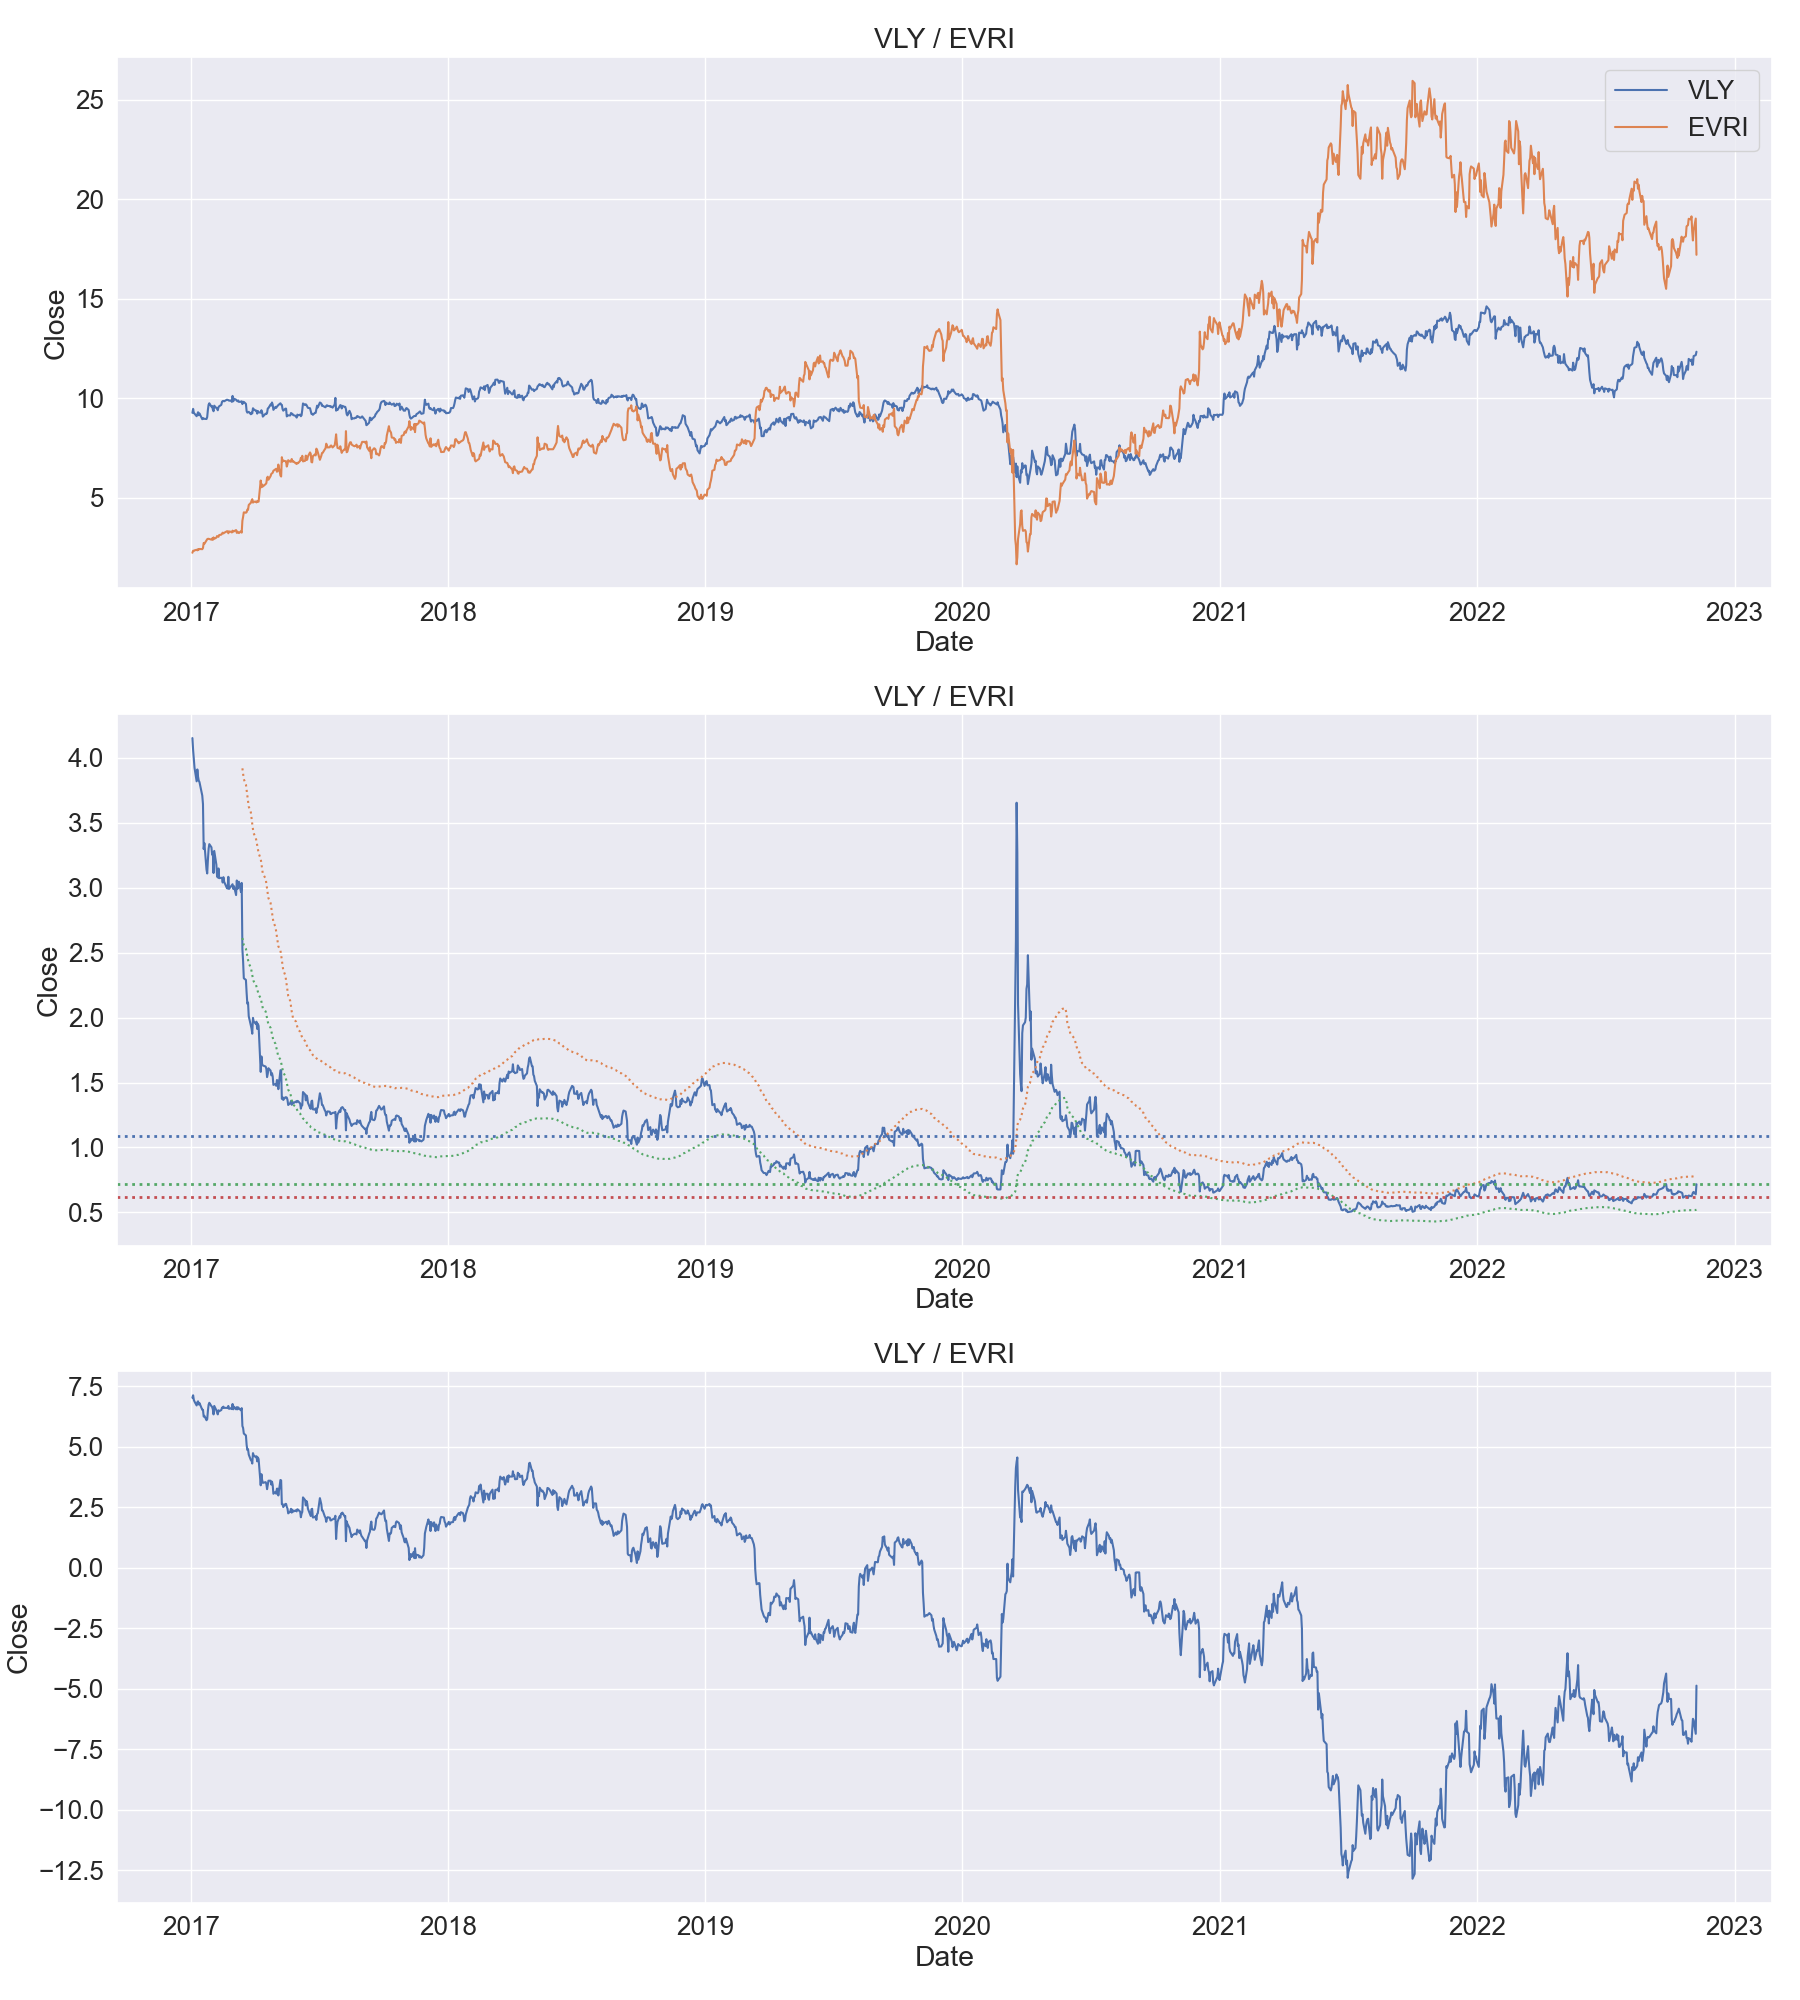

In [12]:
# Technicals:
UpperBand = (ratio.rolling(50).mean()*1.2)
LowerBand = (ratio.rolling(50).mean()*0.8)
Entry = long_entry / short_entry
stop_loss = Entry-(Entry * ((risk1["ATR %"].mean() + risk2["ATR %"].mean())/2))
Target = Entry+((stop_loss*0.2)*3)
print(f"Entry:", np.round(Entry, 2), f"Ratio:", np.round(
    ratio[-1], 2), f"Exit point:", np.round(stop_loss, 2), f"Target:", np.round(Target, 2))

fig, axes = plt.subplots(3, figsize=(18, 20))

axes[0].set_title(f"{buy_ticker} / {sell_ticker}")
sns.lineplot(data=dataFrame1, x="Date", y="Close",
             ax=axes[0], label=buy_ticker)
sns.lineplot(data=dataFrame2, x="Date", y="Close",
             ax=axes[0], label=sell_ticker)

axes[1].set_title(f"{buy_ticker} / {sell_ticker}")
sns.lineplot(data=ratio, ax=axes[1])
sns.lineplot(data=UpperBand, ax=axes[1], linestyle='dotted')
sns.lineplot(data=LowerBand, ax=axes[1], linestyle='dotted')
axes[1].axhline(y=stop_loss, linewidth=2, color='r', linestyle='dotted')
axes[1].axhline(y=Entry, linewidth=2, color='g', linestyle='dotted')
axes[1].axhline(y=Target, linewidth=2, color='b', linestyle='dotted')

axes[2].set_title(f"{buy_ticker} / {sell_ticker}")
sns.lineplot(data=spread, ax=axes[2])


plt.tight_layout(pad=1)
